# Who do "big" donors donate to Biden?

"Big" is a little ambiguous, so let's break it down and compare notes:

1. A "big" donor maxes their contributions to "Biden for President" (`C00703975`)
2. A "big" donor makes > $10k, $50k, $250k in overall DEM donations

We can't use all the sophisticated fuzzy matching to do a full cross product of all FEC donors with themselves, because it will be too slow, but we can do the simplest possible approximation that should at least give us trends (although not useful absolute dollar amounts).

## Preliminaries

Load data and define committees of interest:

In [5]:
# ruff: noqa
from decimal import Decimal
import datetime
from tqdm import tqdm


biden_for_president = "C00703975"
democrat_party = "DEM"


class CommitteeColumns:
	ID = 0
	NAME = 1
	PARTY = 10
	

dem_committees: dict[str, str] = {}

with open("../data/fec/committees-2020.txt") as f:
  for line in tqdm(f, total=18_287):
    line = line.strip().split("|")
    if line[CommitteeColumns.PARTY] == democrat_party:
      dem_committees[line[CommitteeColumns.ID]] = line[CommitteeColumns.NAME]

print(f"Found {len(dem_committees)} explicitly Democratic committees")
assert biden_for_president in dem_committees

100%|██████████| 18287/18287 [00:00<00:00, 1126600.82it/s]

Found 3146 explicitly Democratic committees


Load individual contributions to DEM committees and throw out anything outside of the Nov 2019 - Nov 2020 window.

In [7]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Contributor:
  """A 'unified key' for a single contributor. Imperfect, but so be it."""
  name: str
  city: str
  state: str
  employer: str
  occupation: str
  

class ContributionColumns:
  COMMITTEE_ID = 0
  ENTITY_TYPE = 6
  NAME = 7
  CITY = 8
  STATE = 9
  EMPLOYER = 10
  OCCUPATION = 11
  TRANSACTION_DATE = 13
  TRANSACTION_AMOUNT = 14

contributions: list[tuple[Contributor, datetime.date, str, float]] = []
with open("../data/fec/individual-2020.txt") as f:
  for line in tqdm(f, total=70_659_611):
    splits = line.split("|")
    donating_entity_type = splits[ContributionColumns.ENTITY_TYPE]
    if donating_entity_type != "IND":
      continue
    committee_id = splits[ContributionColumns.COMMITTEE_ID]
    # Get date in MMDDYYYY format
    date_str = splits[ContributionColumns.TRANSACTION_DATE]
    try:
      d = datetime.datetime.strptime(date_str, "%m%d%Y").date()
    except:
      continue
    if d < datetime.date(2019, 11, 3):
      continue
    if d >= datetime.date(2020, 11, 3):
      continue
    amount_usd = float(splits[ContributionColumns.TRANSACTION_AMOUNT])
    if amount_usd <= 0:
      continue
    contributor = Contributor(
      name=splits[ContributionColumns.NAME].upper().strip(),
      city=splits[ContributionColumns.CITY].upper().strip(),
      state=splits[ContributionColumns.STATE].upper().strip(),
      employer=splits[ContributionColumns.EMPLOYER].upper().strip(),
      occupation=splits[ContributionColumns.OCCUPATION].upper().strip(),
    )
    contributions.append((contributor, d, committee_id, amount_usd))

print(f"Found {len(contributions)} contributions")

by_contributor: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}

for contributor, d, committee_id, amount_usd in tqdm(contributions):
  if contributor not in by_contributor:
    by_contributor[contributor] = []
  by_contributor[contributor].append((d, committee_id, amount_usd))

print(f"Found {len(by_contributor)} unique contributors")

100%|██████████| 70659611/70659611 [08:06<00:00, 145160.45it/s] 


Found 48083416 contributions


100%|██████████| 48083416/48083416 [01:48<00:00, 441855.75it/s]

Found 7735318 unique contributors


## Big contributors

Let's define big contributors in a few different ways.

In [15]:
# Find all contributors who gave >= $250,000

big_250k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 250_000:
    big_250k_contributors[contributor] = contributions

# And again for $50k
big_50k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 50_000 and total < 250_000:
    big_50k_contributors[contributor] = contributions

# And again for $10k
big_10k_contributors: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  total = sum(amount_usd for _, _, amount_usd in contributions)
  if total >= 10_000 and total < 50_000:
    big_10k_contributors[contributor] = contributions

print(f"Found {len(big_250k_contributors)} contributors who gave >= $250,000")
print(f"Found {len(big_50k_contributors)} contributors who gave >= $50,000")
print(f"Found {len(big_10k_contributors)} contributors who gave >= $10,000")

100%|██████████| 7735318/7735318 [04:01<00:00, 32050.70it/s] 

Found 1722 contributors who gave >= $250,000
Found 9744 contributors who gave >= $50,000
Found 70650 contributors who gave >= $10,000


Those numbers are small, but remember that we're only looking at explicit DEM party contributions. We know for a fact that there are organizations, like ActBlue, that are not explicitly affiliated with DEM in the FEC database.

Let's graph giving for each.

In [16]:
big_250k_total_by_date: dict[datetime.date, float] = {}
big_50k_total_by_date: dict[datetime.date, float] = {}
big_10k_total_by_date: dict[datetime.date, float] = {}

for contributor, contributions in tqdm(big_250k_contributors.items()):
  for d, _, amount_usd in contributions:
    if d not in big_250k_total_by_date:
      big_250k_total_by_date[d] = 0
    big_250k_total_by_date[d] += amount_usd

# Sort by date
big_250k_total_by_date = dict(sorted(big_250k_total_by_date.items()))

for contributor, contributions in tqdm(big_50k_contributors.items()):
  for d, _, amount_usd in contributions:
    if d not in big_50k_total_by_date:
      big_50k_total_by_date[d] = 0
    big_50k_total_by_date[d] += amount_usd

# Sort by date
big_50k_total_by_date = dict(sorted(big_50k_total_by_date.items()))

for contributor, contributions in tqdm(big_10k_contributors.items()):
  for d, _, amount_usd in contributions:
    if d not in big_10k_total_by_date:
      big_10k_total_by_date[d] = 0
    big_10k_total_by_date[d] += amount_usd

# Sort by date
big_10k_total_by_date = dict(sorted(big_10k_total_by_date.items()))

100%|██████████| 70650/70650 [00:22<00:00, 3106.14it/s] 


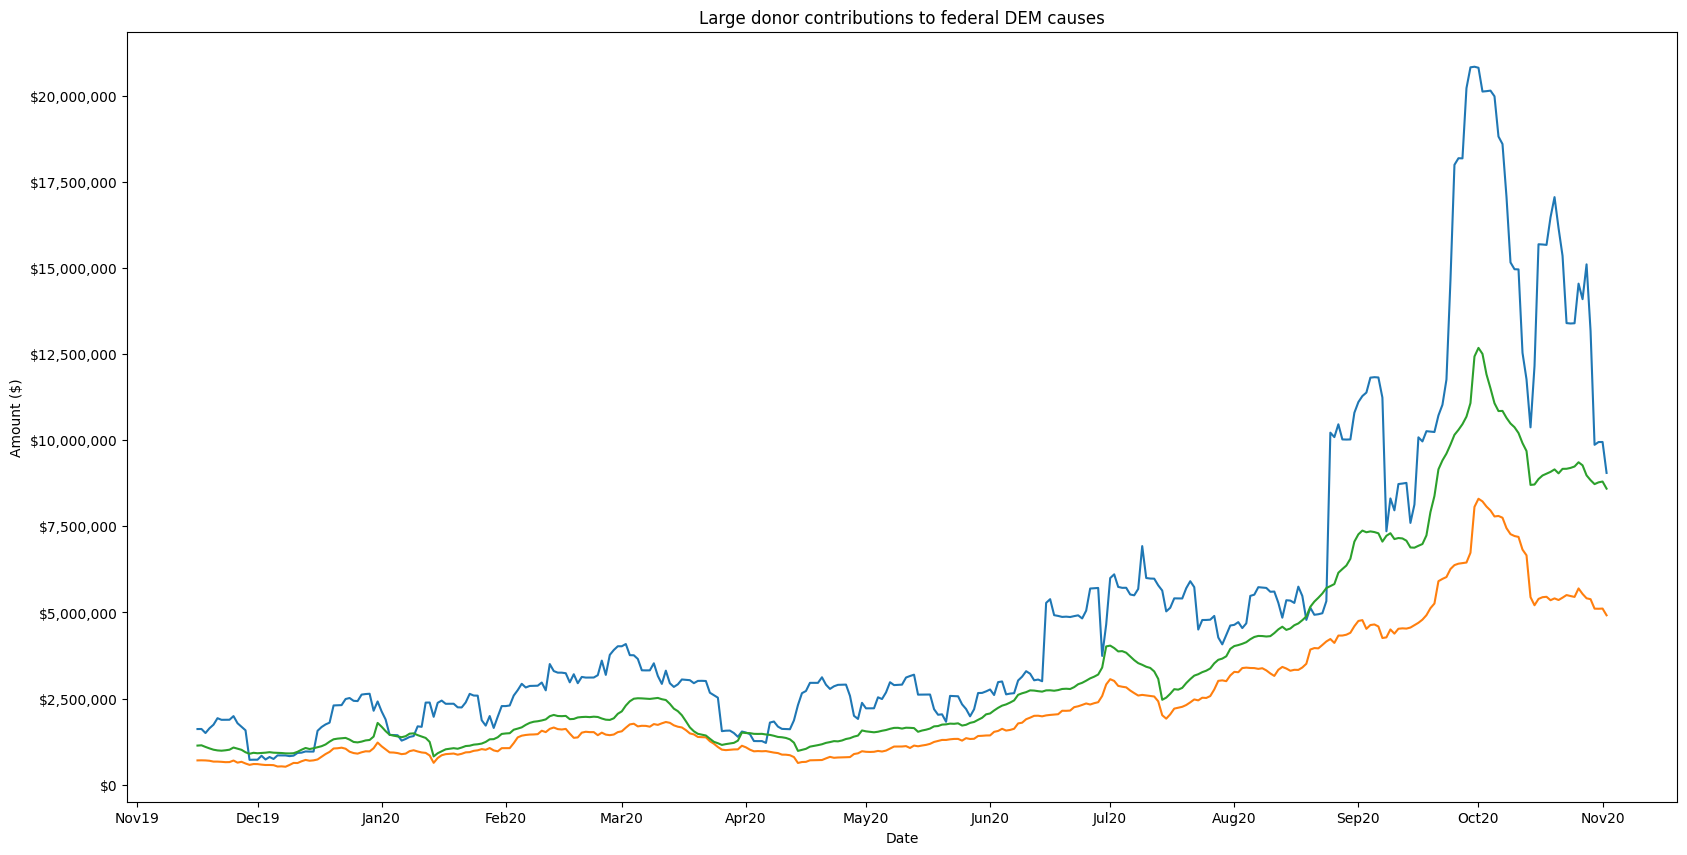

In [19]:
# Make a pandas dataframe for each

import pandas as pd
df_250k = pd.DataFrame(big_250k_total_by_date.items(), columns=["date", "amount"])
df_50k = pd.DataFrame(big_50k_total_by_date.items(), columns=["date", "amount"])
df_10k = pd.DataFrame(big_10k_total_by_date.items(), columns=["date", "amount"])

# Smooth the data by averaging over 14-day windows
df_250k["amount"] = df_250k["amount"].rolling(14).mean()
df_50k["amount"] = df_50k["amount"].rolling(14).mean()
df_10k["amount"] = df_10k["amount"].rolling(14).mean()

# Plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_250k["date"], df_250k["amount"], label=">= $250k")
ax.plot(df_50k["date"], df_50k["amount"], label=">= $50k")
ax.plot(df_10k["date"], df_10k["amount"], label=">= $10k")
ax.set_xlabel("Date")
ax.set_ylabel("Amount ($)")
ax.set_title("Large donor contributions to federal DEM causes")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b%y"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
plt.show()


## Biden only

Let's find out what the pattern of donations is for people who only gave to Biden (`biden_for_president`) and no other DEM committee.

In [20]:
# Let's filter by_contributor to only include (a) donors who gave at least once to `biden_for_president`
# and (b) only those donations that went to `biden_for_president`
biden_donations: dict[Contributor, list[tuple[datetime.date, str, float]]] = {}
for contributor, contributions in tqdm(by_contributor.items()):
  for d, committee_id, amount_usd in contributions:
    if committee_id == biden_for_president:
      if contributor not in biden_donations:
        biden_donations[contributor] = []
      biden_donations[contributor].append((d, committee_id, amount_usd))

print(f"Found {len(biden_donations)} contributors who gave to Biden")

100%|██████████| 7735318/7735318 [03:53<00:00, 33155.12it/s] 

Found 1081883 contributors who gave to Biden


In [21]:
# Summarize biden_donations by date (sorted order)
biden_donations_by_date: dict[datetime.date, float] = {}
for contributor, contributions in tqdm(biden_donations.items()):
  for d, _, amount_usd in contributions:
    if d not in biden_donations_by_date:
      biden_donations_by_date[d] = 0
    biden_donations_by_date[d] += amount_usd

# Sort by date
biden_donations_by_date = dict(sorted(biden_donations_by_date.items()))

100%|██████████| 1081883/1081883 [00:09<00:00, 116575.39it/s]


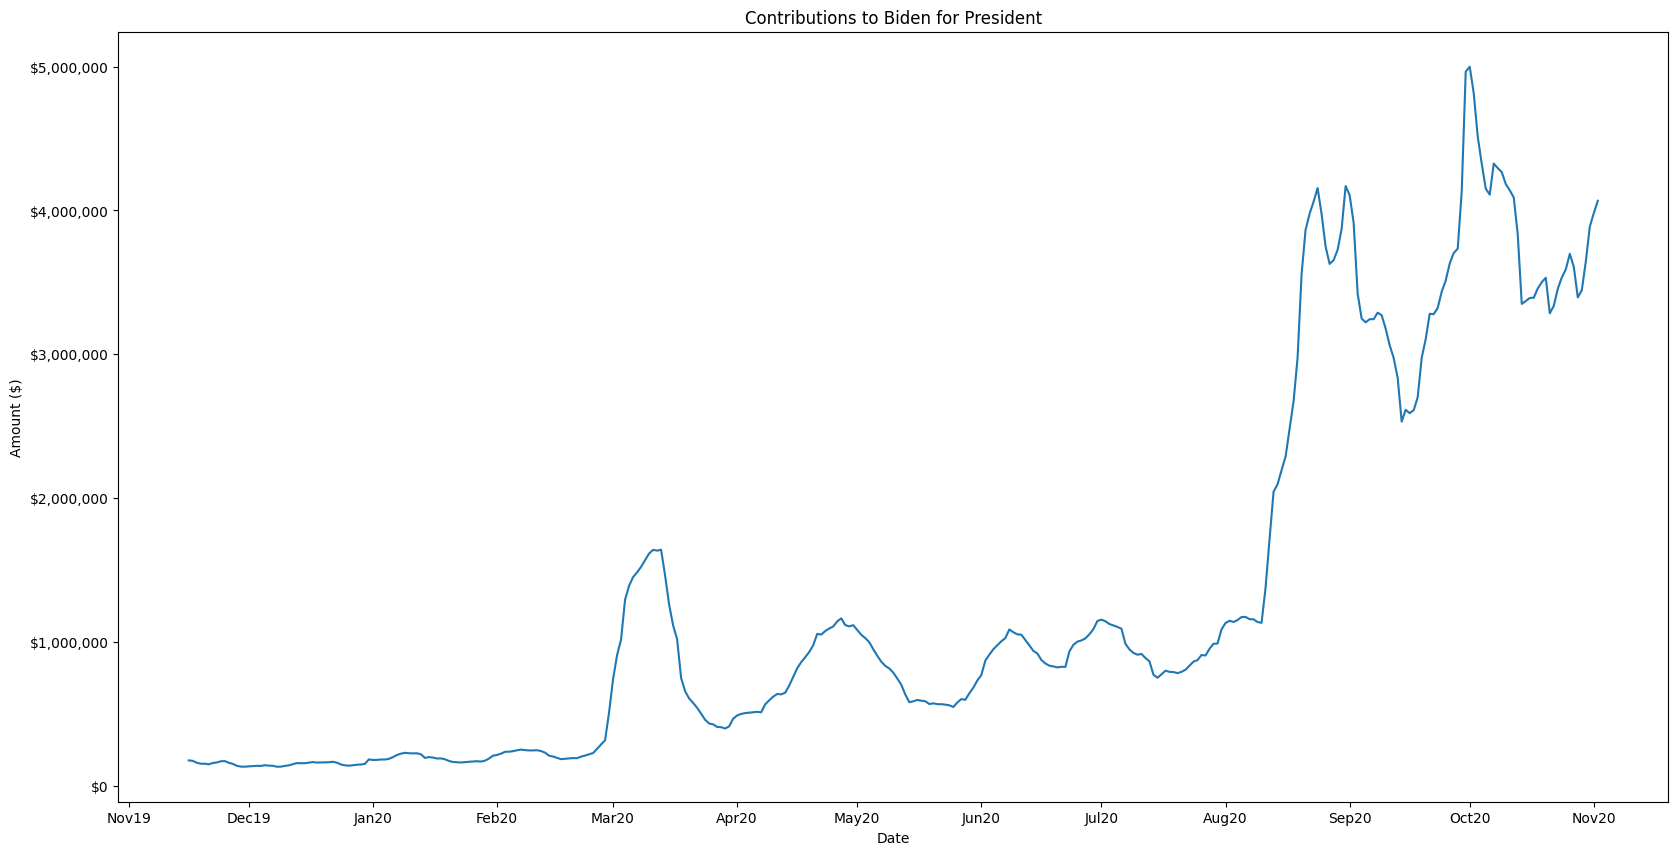

In [22]:
# Make a pandas dataframe
df_biden = pd.DataFrame(biden_donations_by_date.items(), columns=["date", "amount"])

# Smooth it 14-day rolling average
df_biden["amount"] = df_biden["amount"].rolling(14).mean()

# Plot it
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_biden["date"], df_biden["amount"])
ax.set_xlabel("Date")
ax.set_ylabel("Amount ($)")
ax.set_title("Contributions to Biden for President")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b%y"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
plt.show()

